# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***LIBRARIES***

In [ ]:
import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from tqdm import tqdm

#torch.manual_seed(123)
np.random.seed(123)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define the WaveAct activation function
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return torch.nn.functional.softplus(x) + 0.005 * torch.sin(x)

# Define the FeedForward module
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=200):
        super(FeedForward, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.linear(x)

# Define the EncoderLayer module
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x):
        x2 = self.act1(x)
        x = x + self.attn(x2, x2, x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

# Define the DecoderLayer module
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        # Manually define N encoder layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(N)])
        self.act = WaveAct()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.act(x)

# Define the Decoder module
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        # Manually define N decoder layers
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(N)])
        self.act = WaveAct()

    def forward(self, x, e_outputs):
        for layer in self.layers:
            x = layer(x, e_outputs)
        return self.act(x)

# Define the PINNsformer model
class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()
        self.linear_emb = nn.Linear(2, d_model)  # Input dimension is 3 (S, sigma, t)
        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x):
        src = self.linear_emb(x)
        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.7, 149.6])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.8, 149.5])


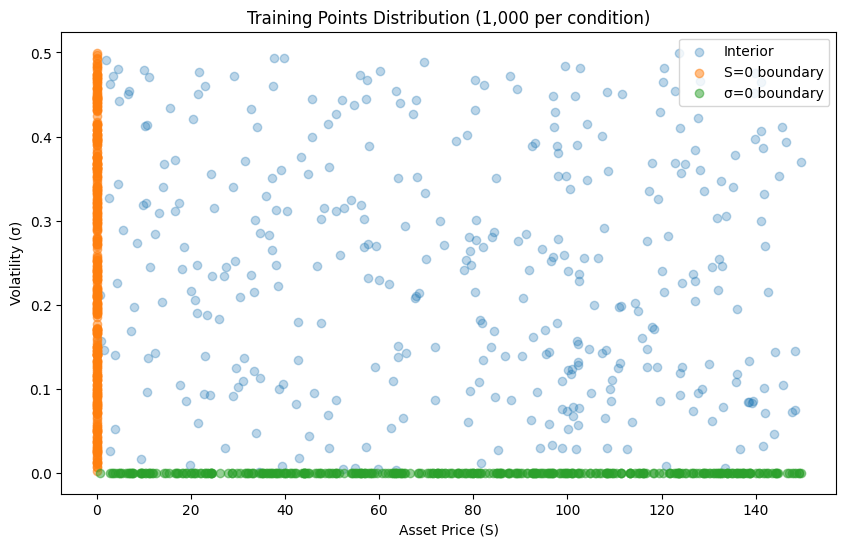

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

# ***ANALYTICAL BS - MONTE CARLO***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices


# ***PDE AND PINN CONDITIONS***

In [ ]:
# Black-Scholes PDE
def BS_pde_residual(model, S, t, sigma, r):
    C = model(torch.cat([S, t], dim=1).to(device))
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    pde = C_t + 0.5 * sigma**2 * S**2 * C_SS + r * S * C_S - r * C
    return pde

# Black-Scholes boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min.to(device))  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

def Smax_conditions(model, inputs_S_max, K, r):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1).to(device)
    Smax_t = inputs_S_max[:, 1].requires_grad_(True).reshape(-1, 1).to(device)

    V_S_max = model(inputs_S_max)
    boundary_S_max = V_S_max - fSmax +  K * torch.exp(-r * (Smax_t))
    boundary_S_max = torch.mean(boundary_S_max**2)

    return boundary_S_max

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))
    return val.view(-1, 1).requires_grad_(True)

# ***CALIBRATION***

In [ ]:
def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    """ Computes the SABR model implied volatility using Hagan's formula """
    if F == K:  # ATM case
        FK_beta = F**(1 - beta)
        vol = alpha / FK_beta * (1 + (((1 - beta) ** 2) / 24 * (alpha**2 / FK_beta**2) +
                                     (1 / 4) * (rho * beta * nu * alpha / FK_beta) +
                                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K) ** ((1 - beta) / 2)
        term1 = (1 + ((((1-beta)**2)/24)*((alpha**2)/FK_beta**2) +
                     (1 / (4*FK_beta)) * (rho * beta * nu * alpha) +
                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
        term2 = (1 + ((((1 - beta) ** 2) / 24) * ((np.log(F/K)) ** 2)) +
                 ((((1 - beta) ** 4) / 1920) * ((np.log(F/K)) ** 4)))
        vol = (alpha / FK_beta) * (z / x_z) * term1 / term2
    return vol

# Loss function to minimize
def sabr_loss(params, F, strikes, T, market_vols):
    alpha, beta, rho, nu = params
    model_vols = np.array([sabr_volatility(alpha, beta, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols) ** 2)

# ***CALLING REAL DATASET***

In [ ]:
# Load all sheets in the Excel file
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/european_options.xlsx"
sheet_names = pd.ExcelFile(excel_file).sheet_names

results_MC_df = pd.DataFrame(columns=["Sheet", "BS Model MSE", "BS Model MAPE"])

prediction_df = pd.DataFrame()

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/BSFormer"
os.makedirs(output_dir, exist_ok=True)

# ***TRAINING***

In [ ]:
#start = time.time()
for sheet_name in sheet_names:
    print(f"Processing sheet: {sheet_name}")
    # Load data for the current sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Verileri işleyin
    F = df['close'].values  # SPOT PRICE
    spot_price = df['close'].iloc[0]
    sigma = df['implied_volatility'].values
    K = df['strike'].values
    market_prices = df['Option_mid'].values
    time = df['Remaining_day'].values / 252

        # Initial guess for SABR parameters
    initial_guess = [sigma[0], 1, 0.0, 0.3]

        # Optimize SABR parameters
    result_parameters = minimize(sabr_loss, initial_guess, args=(F[0], K, time[0], sigma),
                              bounds=[(0.01, 1), (0, 1), (-0.99, 0.99), (0.01, None)])

    alfa, beta, rho, nu = result_parameters.x

    print("Optimized SABR parameters:")
    print("Alpha:", alfa)
    print("Beta:", beta)
    print("Rho:", rho)
    print("Nu:", nu)

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

    F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
    v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

    r=0.0007

    lambda1, lambda2 = 1, 1

    model = PINNsformer(d_out=1, d_model=4, d_hidden=512, N=1, heads=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-5)


    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=200,
        min_lr=2e-5)    # Early stopping parameters

    early_stopping = EarlyStopping(patience=500, min_delta=1e-4)

    best_loss = float('inf')
    save_path = 'best_model.pth'

    totallosses=[]
    Lic_list = []
    Lpde_list = []
    Lbd_list = []
    Lbd_Smax_list = []
    Lbd_Smin_list = []

    for i in range(1000):
        data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

        t0 = data['initial'].clone().detach().requires_grad_(True).to(device)
        S0 = data['bd_S0'].clone().detach().requires_grad_(True).to(device)
        Smax = data['bd_Smax'].clone().detach().requires_grad_(True).to(device)
        inputs = data['interior'].clone().detach().requires_grad_(True).to(device)
        inputs_all = data['all'].clone().detach().requires_grad_(True).to(device)

        t0_bs = torch.cat([t0[:, 0].requires_grad_(True).reshape(-1, 1), t0[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1).to(device)

        input_bs = torch.cat([inputs[:, 0].requires_grad_(True).reshape(-1, 1), inputs[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1).to(device)


        C0 = model(t0_bs)
        loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1).to(device), K[0]))**2
        Lic = lambda1 * loss1.mean()

    # Compute the PDE residual as the loss
        residual = BS_pde_residual(model, inputs[:,0].requires_grad_(True).reshape(-1, 1).to(device),
                                 inputs[:,2].requires_grad_(True).reshape(-1, 1).to(device),
                                 inputs[:,1].requires_grad_(True).reshape(-1, 1).to(device), r)

        Lpde = lambda2 * torch.mean(residual**2)


        S0_bs = torch.cat([S0[:, 0].requires_grad_(True).reshape(-1, 1), S0[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1).to(device)
        bnd_S_min = Smin_conditions(model, S0_bs)

        Smax_bs = torch.cat([Smax[:, 0].requires_grad_(True).reshape(-1, 1), Smax[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1).to(device)
        bnd_S_max = Smax_conditions(model, Smax_bs, K[0], r)

        Lbd = ( 1*bnd_S_max + 1*bnd_S_min)
        Lic2 = 1*Lic
        Lpde2 = 1*Lpde
        loss = Lic2 + Lpde2 + Lbd

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

        totallosses.append(loss.item())
        Lic_list.append(Lic2.item())
        Lpde_list.append(Lpde2.item())
        Lbd_list.append(Lbd.item())

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
            print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
            print("CURRENT LR:", scheduler.get_last_lr())

        # En iyi model
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': best_loss,
              'iteration': i
              }, save_path)

    print("best loss: ", best_loss )

    checkpoint = torch.load("best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
    time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)
    inputs_bs = torch.cat([F_torch, time_torch], dim=1).to(device)

    C = model(inputs_bs) # PINN OPTION PRICES

    C = C.detach().cpu().numpy()

    bs_op_pr = black_scholes_option_price(F, K[0], time, r, sigma) # ANALYTICAL BS OPTION PRICES

    mc = sabr_european_call_mc(F, sigma, time, K[0], r, beta, nu, rho, N=100, M=10000, confidence=0.95) # MONTE CARLO OPTIONS PRİCES

    plt.plot(time, C, label="BS-PINN", linestyle='dashed')
    plt.plot(time, bs_op_pr, label="Analytical BS Values")
    plt.plot(time, mc, label="Monte Carlo Values")
    plt.xlabel("Time (t)")
    plt.ylabel("Option Price (C)")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{sheet_name}_bs_option_price_plot_time.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

    mse1 = np.mean((mc - C.ravel())**2)
    mape1 = np.mean(np.abs((mc - C.ravel()) / mc))
    print("MSE between MC and PINN:", mse1)
    print("MAPE between MC and PINN::", mape1)

    new_row = pd.DataFrame({
    "Sheet": [sheet_name],
    "BS Model MSE": [mse1],
    "BS Model MAPE": [mape1],
    })

    results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)

    prediction_df[f'BS_{sheet_name}'] = pd.Series(C.flatten())



Processing sheet: XEO
Optimized SABR parameters:
Alpha: 0.16391512114306103
Beta: 0.9999999584026403
Rho: -0.004711434880146214
Nu: 0.3046928300850347


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Iteration 0, Loss: 126159.9375
Loss-1 (IC): 11707.8203125, Loss-2 (pde): 6884.43701171875 , Loss-5 (bd): 107567.6796875
CURRENT LR: [2e-05]
Iteration 100, Loss: 56127.04296875
Loss-1 (IC): 10516.056640625, Loss-2 (pde): 10352.3388671875 , Loss-5 (bd): 35258.6484375
CURRENT LR: [2e-05]
Iteration 200, Loss: 46977.23046875
Loss-1 (IC): 12097.9814453125, Loss-2 (pde): 15984.1083984375 , Loss-5 (bd): 18895.140625
CURRENT LR: [2e-05]
Iteration 300, Loss: 36521.296875
Loss-1 (IC): 11621.3857421875, Loss-2 (pde): 9976.1767578125 , Loss-5 (bd): 14923.732421875
CURRENT LR: [2e-05]
Iteration 400, Loss: 22184.58203125
Loss-1 (IC): 14544.33203125, Loss-2 (pde): 784.4423828125 , Loss-5 (bd): 6855.80859375
CURRENT LR: [2e-05]
Iteration 500, Loss: 24218.9609375
Loss-1 (IC): 10889.904296875, Loss-2 (pde): 1643.828125 , Loss-5 (bd): 11685.2294921875
CURRENT LR: [2e-05]
Iteration 600, Loss: 283691.03125
Loss-1 (IC): 11757.701171875, Loss-2 (pde): 264714.0625 , Loss-5 (bd): 7219.28515625
CURRENT LR: [2e-0

/tmp/ipython-input-4271455624.py:176: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)


Optimized SABR parameters:
Alpha: 0.37870372003511654
Beta: 0.9998338414020369
Rho: -0.23720622531737695
Nu: 0.7698718433798445
Iteration 0, Loss: 1389.7916259765625
Loss-1 (IC): 204.72982788085938, Loss-2 (pde): 0.05205824226140976 , Loss-5 (bd): 1185.009765625
CURRENT LR: [2e-05]
Iteration 100, Loss: 500.50152587890625
Loss-1 (IC): 121.9079818725586, Loss-2 (pde): 65.93599700927734 , Loss-5 (bd): 312.65753173828125
CURRENT LR: [2e-05]
Iteration 200, Loss: 255.222900390625
Loss-1 (IC): 186.77606201171875, Loss-2 (pde): 7.137812614440918 , Loss-5 (bd): 61.30902862548828
CURRENT LR: [2e-05]
Iteration 300, Loss: 213.59303283691406
Loss-1 (IC): 182.50064086914062, Loss-2 (pde): 3.4448044300079346 , Loss-5 (bd): 27.647586822509766
CURRENT LR: [2e-05]
Iteration 400, Loss: 202.40174865722656
Loss-1 (IC): 187.6646728515625, Loss-2 (pde): 2.9952428340911865 , Loss-5 (bd): 11.741829872131348
CURRENT LR: [2e-05]
Iteration 500, Loss: 176.57373046875
Loss-1 (IC): 169.54713439941406, Loss-2 (pde): 

# ***SAVING***

In [ ]:
results_file = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/BSFormer/MSE_MAPE_Results_analytic.xlsx"
results_MC_df.to_excel(results_file, index=False)
print(f"Results saved to {results_file}")

results_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/new/euro/BSFormer/Predictions.xlsx"
prediction_df.to_excel(results_file2, index=False)
print(f"Results saved to {results_file2}")

Results saved to /content/drive/MyDrive/Bitirme_real_dataset/new/euro/BSFormer/MSE_MAPE_Results_analytic.xlsx
Results saved to /content/drive/MyDrive/Bitirme_real_dataset/new/euro/BSFormer/Predictions.xlsx


In [ ]:
print(f"Total execution time: {end - start} seconds")
